### Load libraries

In [3]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import os
import re
from torch import nn, optim
import torch.nn.functional as F
from datetime import datetime
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from collections import Counter
from nltk.util import ngrams
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
# Set the seed for reproducibility
seed = 265
torch.manual_seed(seed)

### Load data

In [4]:
train_paths = [
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/candide.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/dracula.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/enchiridion.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/grimm_fairy_tales.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/Heimskringla.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/manual_of_gardening.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/meditations.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/miserables.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/poirot_investigates.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/the_adventures_of_sherlock_holmes.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/the_monomaniac.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/under_fire.txt',
    '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_train/war_and_peace.txt'
]
val_path = ['/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_val/a_study_in_scarlet.txt']
test_path = [ '/Users/angelgarealamas/Desktop/project3/inf265_v24_project03_data/data_test/Twenty_Thousand_Leagues_under_the_Sea.txt']


### General Functions

In [5]:
# Initialize constants and tokenizer
TOKENIZER_EN = get_tokenizer('basic_english')
PATH_GENERATED = './generated/'
MIN_FREQ = 100

In [6]:
def read_files(file_paths):
    """
    Read files from a list of file paths and return their contents as a list of lines.
    """
    lines = []
    for file_path in file_paths:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                lines.extend(file.readlines())
        except Exception as e:
            print(f"Failed to read {file_path}: {str(e)}")
    return lines


def tokenize(lines, tokenizer=TOKENIZER_EN):
    """
    Tokenize the list of lines
    """
    list_text = []
    for line in lines:
        list_text += tokenizer(line)
    return list_text


def yield_tokens(lines, tokenizer=TOKENIZER_EN):
    """
    Yield tokens, ignoring names and digits to build vocabulary
    """
    # Match any word containing digit
    no_digits = '\w*[0-9]+\w*'
    # Match word containing a uppercase 
    no_names = '\w*[A-Z]+\w*'
    # Match any sequence containing more than one space
    no_spaces = '\s+'
    
    for line in lines:
        line = re.sub(no_digits, ' ', line)
        line = re.sub(no_names, ' ', line)
        line = re.sub(no_spaces, ' ', line)
        yield tokenizer(line)

def count_freqs(words, vocab):
    """
    Count occurrences of each word in vocabulary in the data
    
    Useful to get some insight on the data and to compute loss weights
    """
    freqs = torch.zeros(len(vocab), dtype=torch.int)
    for w in words:
        freqs[vocab[w]] += 1
    return freqs

def create_vocabulary(lines, min_freq=MIN_FREQ):
    """
    Create a vocabulary (list of known tokens) from a list of strings
    """
    # vocab contains the vocabulary found in the data, associating an index to each word
    vocab = build_vocab_from_iterator(yield_tokens(lines), min_freq=min_freq, specials=["<unk>"])
    # Since we removed all words with an uppercase when building the vocabulary, we skipped the word "I"
    vocab.append_token("i")
    # Value of default index. This index will be returned when OOV (Out Of Vocabulary) token is queried.
    vocab.set_default_index(vocab["<unk>"])
    return vocab

### Read and tokenize

In [7]:
# Read and tokenize training data
train_lines = read_files(train_paths)
train_tokens = tokenize(train_lines)

# Read and tokenize validation data
val_lines = read_files(val_path)
val_tokens = tokenize(val_lines)

# Read and tokenize test data
test_lines = read_files(test_path)
test_tokens = tokenize(test_lines)

# Show some basic statistics
print(f"Total number of lines train: {len(train_lines)}")
print(f"Total number of tokens train: {len(train_tokens)}")

print(f"Total number of lines val: {len(val_lines)}")
print(f"Total number of tokens val: {len(val_tokens)}")

print(f"Total number of lines test: {len(test_lines)}")
print(f"Total number of tokens test: {len(test_tokens)}")

Total number of lines train: 268380
Total number of tokens train: 2684706
Total number of lines val: 4649
Total number of tokens val: 49526
Total number of lines test: 12696
Total number of tokens test: 124152


### Create vocabulary

In [8]:
VOCAB_FNAME = "vocabulary.pt"
# Load vocabulary if you have already generated it
# Otherwise, create it and save it
if os.path.isfile(PATH_GENERATED + VOCAB_FNAME):
    train_vocab = torch.load(PATH_GENERATED + VOCAB_FNAME)
else:
    # Create vocabulary based on the words in the training dataset
    train_vocab = create_vocabulary(train_lines, MIN_FREQ)
    torch.save(train_vocab, PATH_GENERATED + VOCAB_FNAME)
    

# Count the frequency of each word in the vocabulary
train_freqs = count_freqs(train_tokens, train_vocab)

# Calculate and display the desired statistics
total_tokens_train = len(train_tokens)  # Total number of tokens in the training dataset
distinct_tokens_train = len(set(train_tokens))  # Number of distinct tokens in the training dataset
vocab_size = len(train_vocab)  # Size of the vocabulary

# Displaying the calculated statistics
print(f"Total number of tokens in the training dataset: {total_tokens_train}")
print(f"Number of distinct tokens in the training dataset: {distinct_tokens_train}")
print(f"Size of the vocabulary (words appearing at least {MIN_FREQ} times): {vocab_size}")

Total number of tokens in the training dataset: 2684706
Number of distinct tokens in the training dataset: 52105
Size of the vocabulary (words appearing at least 100 times): 1880


### Analyze vocabulary


Word Frequencies:
,: 182537
the: 151278
.: 123727
and: 82289
of: 65661
to: 62763
a: 49230
in: 41477
he: 37167
that: 31052

Vocabulary covers 83.84% of the total words in the dataset


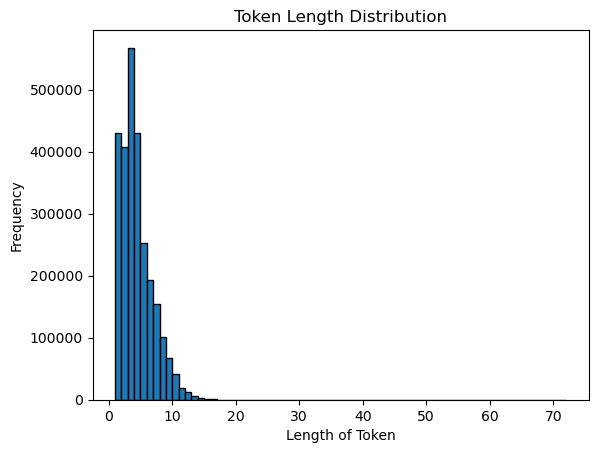

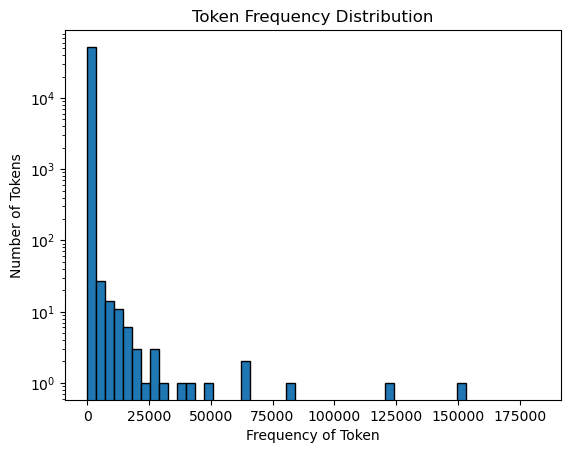


Number of rare tokens (appearing only once): 21986
Example rare tokens: ['nosepiece', 'narýshkina', 'joinings', 'billet-doux', 'canny', 'saint-saulve', 'luffa', '$24', 'lartif', 'post-haste']

Number of common tokens (appearing at least 100 times): 2091
Example common tokens: ['shoulder', 'quarters', 'walked', 'front', 'court', 'staff', 'chosen', 'public', 'repeated', 'friendship']


In [9]:
def analyze_vocabulary(tokens, vocab, min_freq):
    # Count occurrences of each word in the token list
    token_counts = {}
    for token in tokens:
        if token in token_counts:
            token_counts[token] += 1
        else:
            token_counts[token] = 1

    # Calculate the frequency of words in the vocabulary
    vocab_freqs = {word: token_counts.get(word, 0) for word, idx in vocab.get_stoi().items()}

    # Display word frequencies
    print("\nWord Frequencies:")
    for word, freq in sorted(vocab_freqs.items(), key=lambda item: item[1], reverse=True)[:10]:  # top 10 words
        print(f"{word}: {freq}")

    # Calculate and display vocabulary coverage
    total_words = sum(token_counts.values())
    covered_words = sum(vocab_freqs.values())
    coverage = (covered_words / total_words) * 100
    print(f"\nVocabulary covers {coverage:.2f}% of the total words in the dataset")

    # Analyze token lengths
    token_lengths = [len(token) for token in tokens]
    plt.figure()
    plt.hist(token_lengths, bins=range(1, max(token_lengths) + 1), edgecolor='black')
    plt.title('Token Length Distribution')
    plt.xlabel('Length of Token')
    plt.ylabel('Frequency')
    plt.show()

    # Frequency distribution of tokens
    freq_values = list(token_counts.values())
    plt.figure()
    plt.hist(freq_values, bins=range(1, max(freq_values) + 1, max(freq_values) // 50), log=True, edgecolor='black')
    plt.title('Token Frequency Distribution')
    plt.xlabel('Frequency of Token')
    plt.ylabel('Number of Tokens')
    plt.show()

    # Information about rare and common tokens
    rare_tokens = {word for word, freq in token_counts.items() if freq == 1}
    common_tokens = {word for word, freq in token_counts.items() if freq >= 100}

    print(f"\nNumber of rare tokens (appearing only once): {len(rare_tokens)}")
    print(f"Example rare tokens: {list(rare_tokens)[:10]}")  # showing 10 rare tokens
    print(f"\nNumber of common tokens (appearing at least 100 times): {len(common_tokens)}")
    print(f"Example common tokens: {list(common_tokens)[:10]}")  # showing 10 common tokens

    return vocab_freqs, token_counts

# Apply the function to the training data
train_vocab_freqs, train_token_counts = analyze_vocabulary(train_tokens, train_vocab, MIN_FREQ)

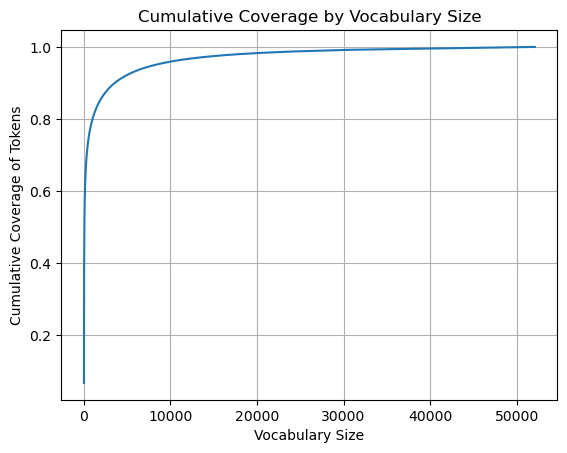


Example sentence with a rare word:
it is the independence of personality—free will.

Example sentence with a common word:
conscious.

Most Common Bigrams:
(',', 'and'): 35260
('of', 'the'): 17655
('in', 'the'): 12133
('.', 'the'): 11791
('to', 'the'): 8279
(',', 'the'): 7643
('.', 'he'): 7192
('on', 'the'): 5849
('and', 'the'): 5746
('.', 'i'): 5709


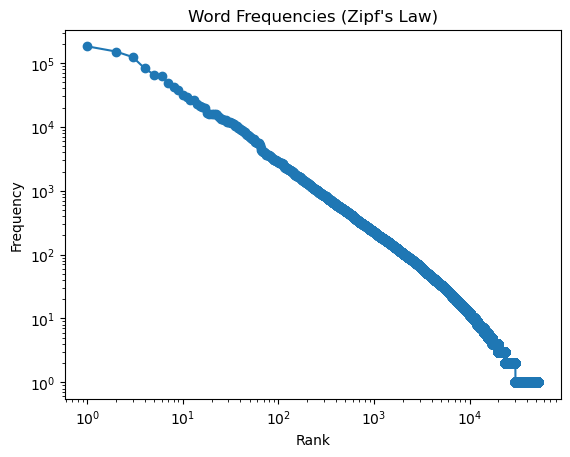


Entropy of the dataset: 9.42 bits per word


In [10]:
def analyze_text_complexity(tokens, vocab):
    # Calculate and plot cumulative coverage by vocabulary
    token_frequency = Counter(tokens)
    ordered_tokens = sorted(token_frequency.items(), key=lambda x: x[1], reverse=True)
    
    cumulative_tokens = np.cumsum([freq for _, freq in ordered_tokens])
    total_tokens = cumulative_tokens[-1]
    cumulative_coverage = cumulative_tokens / total_tokens

    plt.figure()
    plt.plot(cumulative_coverage)
    plt.title('Cumulative Coverage by Vocabulary Size')
    plt.xlabel('Vocabulary Size')
    plt.ylabel('Cumulative Coverage of Tokens')
    plt.grid(True)
    plt.show()

    # Sample usage of rare and common words
    rare_words = {word for word, freq in token_frequency.items() if freq == 1}
    common_words = {word for word, freq in token_frequency.items() if freq > 100}
    sample_sentences = {}
    for line in train_lines:
        line_tokens = TOKENIZER_EN(line)
        if rare_words.intersection(line_tokens):
            sample_sentences['rare'] = line.strip()
        if common_words.intersection(line_tokens):
            sample_sentences['common'] = line.strip()

    print("\nExample sentence with a rare word:")
    print(sample_sentences.get('rare', 'No example available'))

    print("\nExample sentence with a common word:")
    print(sample_sentences.get('common', 'No example available'))

    # Most common bigrams
    bigrams = ngrams(tokens, 2)
    most_common_bigrams = Counter(bigrams).most_common(10)
    print("\nMost Common Bigrams:")
    for bigram, freq in most_common_bigrams:
        print(f"{bigram}: {freq}")

    # Zipf's Law visualization
    ranks = range(1, len(ordered_tokens) + 1)
    frequencies = [freq for _, freq in ordered_tokens]
    
    plt.figure()
    plt.loglog(ranks, frequencies, marker="o")
    plt.title('Word Frequencies (Zipf\'s Law)')
    plt.xlabel('Rank')
    plt.ylabel('Frequency')
    plt.show()

    # Calculate entropy
    probabilities = [freq / total_tokens for freq in frequencies]
    entropy = -sum(p * np.log2(p) for p in probabilities if p > 0)
    print(f"\nEntropy of the dataset: {entropy:.2f} bits per word")

# Execute the complex analysis
analyze_text_complexity(train_tokens, train_vocab)


In [11]:
# Ensure that NLTK resources are downloaded
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')

def analyze_verbs(tokens, verb_list):
    # Filter tokens to only include words (lowercase for uniformity)
    words = [word.lower() for word in tokens if word.isalpha()]

    # Get parts of speech for each word
    tagged_words = pos_tag(words)

    # Dictionary to hold counts of each verb form
    verb_forms = defaultdict(int)

    # Count occurrences of each form of the verbs 'be' and 'have'
    for word, tag in tagged_words:
        if word in verb_list:
            verb_forms[word] += 1

    # Display the counts of each verb form
    for verb, count in verb_forms.items():
        print(f"{verb}: {count} times")

    # Find and display common contexts of these verbs
    text = nltk.Text(tokens)
    for verb in verb_list:
        print(f"\nCommon contexts for '{verb}':")
        text.concordance(verb, lines=5)  # Display 5 examples of each

# List of common forms of 'be' and 'have'
be_forms = ['am', 'is', 'are', 'was', 'were', 'being', 'been']
have_forms = ['have', 'has', 'had', 'having']

# Collect all relevant forms in one list for analysis
all_verbs = be_forms + have_forms

# Execute the verb analysis
analyze_verbs(train_tokens, all_verbs)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/angelgarealamas/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/angelgarealamas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelgarealamas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


was: 29046 times
had: 20159 times
being: 1678 times
have: 10205 times
been: 5446 times
having: 1272 times
were: 8219 times
is: 19965 times
are: 8800 times
has: 3817 times
am: 2169 times

Common contexts for 'am':
Displaying 5 of 2169 matches:
is for the best in this world , for i am infinitely more touched by your extre
 girls , and nature s masterpiece ? i am so weak that i cannot stand , said pa
my part i shall give it to nobody , i am dying . oh , pangloss ! cried candide
blood and fury ! answered the other i am a sailor and born at batavia . four t
loss , get me a little wine and oil i am dying . this concussion of the earth 

Common contexts for 'is':
Displaying 5 of 19965 matches:
logy . he proved admirably that there is no effect without a cause , and that 
 best of all possible baronesses . it is demonstrable , said he , that things 
or all being created for an end , all is necessarily for the best end . observ
consequently they who assert that all is well have said a foolish t

### Train and accuracy functions

In [38]:
def set_device(device=None):
    """
    Helper function to set device
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"On device: {device}")
    return device


def train(n_epochs, optimizer, model, loss_fn, train_loader, device=None):
    device = set_device(device)

    n_batch = len(train_loader)
    losses_train = []
    model.train()
    optimizer.zero_grad(set_to_none=True)

    for epoch in range(1, n_epochs + 1):

        loss_train = 0.0
        for contexts, targets in train_loader:

            contexts = contexts.to(device=device)
            targets = targets.to(device=device)

            outputs = model(contexts)

            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_train += loss.item()

        losses_train.append(loss_train / n_batch)

        if epoch == 1 or epoch % 5 == 0:
            print('{}  |  Epoch {}  |  Training loss {:.5f}'.format(
                datetime.now().time(), epoch, loss_train / n_batch))
    return losses_train

def compute_accuracy(model, loader, device=None):

    model.eval()  # Set the model to evaluation mode
    device = device or torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    correct, total = 0, 0

    with torch.no_grad():
        for contexts, targets in loader:
            contexts = contexts.to(device)  # Move data to the appropriate device
            targets = targets.to(device)    # Move targets to the appropriate device

            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)  # Get the class with the highest probability

            total += targets.size(0)                 # Increment the total count
            correct += (predicted == targets).sum().item()  # Increment the correct count

    accuracy = correct / total  # Calculate accuracy
    return accuracy

### Compute labels and create the datasets

In [39]:
def compute_label(w):
    if w == '<unk>':
        return 0
    elif w in [',', '.', '(', ')', '?', '!']:
        return 1
    else:
        return 2

# It must execute after having created the vocabulary
MAP_TARGET = {
    train_vocab[w]: compute_label(w) for w in train_vocab.get_itos()
}

CONTEXT_SIZE = 3

def create_dataset(text, vocab, context_size=3, map_target=MAP_TARGET):
    """
    Create a pytorch dataset of context / target pairs from a text
    """
    
    n_text = len(text)
    
    # Transform the text into a list of integers, ensuring that only words in the vocabulary are included
    txt = [vocab[token] if token in vocab.get_stoi() else vocab['<unk>'] for token in text]

    contexts = []
    targets = []
    for i in range(n_text - context_size):
        # Context son las 'context_size' palabras antes de la palabra objetivo
        context = txt[i:i + context_size]
        # Palabra usada como target
        target = txt[i + context_size]

        # Asegurarse de que el target está en map_target
        if target in map_target:
            targets.append(map_target[target])
            contexts.append(torch.tensor(context, dtype=torch.long))

    contexts = torch.stack(contexts)
    targets = torch.tensor(targets, dtype=torch.long)
    # Create a PyTorch dataset with these context/target pairs
    return TensorDataset(contexts, targets)



def load_dataset(words, vocab, fname):
    # Asegurarse de que el directorio existe
    if not os.path.exists(PATH_GENERATED):
        os.makedirs(PATH_GENERATED)
    
    # Si ya está generado
    if os.path.isfile(PATH_GENERATED + fname):
        dataset = torch.load(PATH_GENERATED + fname)
    else:
        # Crear dataset de contexto/target basado en la lista de strings
        dataset = create_dataset(words, vocab)
        torch.save(dataset, PATH_GENERATED + fname)
    return dataset



### Task 2.1: Word embedding

In [58]:
data_train = load_dataset(train_tokens, train_vocab, "data_train.pt")
data_val = load_dataset(val_tokens, train_vocab, "data_val.pt")
data_test = load_dataset(test_tokens, train_vocab, "data_test.pt")


In [74]:
data_train = torch.load("/Users/angelgarealamas/Desktop/3old/generated/data_train.pt")
data_val = torch.load("/Users/angelgarealamas/Desktop/3old/generated/data_val.pt")
data_test = torch.load("/Users/angelgarealamas/Desktop/3old/generated/data_test.pt") 

In [75]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize the model
embedding_layer = nn.Embedding(len(train_vocab), 50)  
# Randomly initialize embedding weights or load your pretrained weights here
embedding_layer.weight.data.copy_(torch.randn(embedding_layer.weight.shape))

# Data loaders
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

# Set the number of epochs
n_epochs = 10

Using device: cpu


In [78]:
class TransformerEmbedder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=50, nhead=5, num_encoder_layers=3, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

    def forward(self, x, mask=None):
        embedded = self.embedding(x)  # Embedding layer output
        if mask is not None:
            embedded = embedded.transpose(0, 1)  # Transformer expects (sequence_length, batch_size, embedding_dim)
            output = self.transformer_encoder(embedded, src_key_padding_mask=mask)
            output = output.transpose(0, 1)  # Back to (batch_size, sequence_length, embedding_dim)
        else:
            embedded = embedded.transpose(0, 1)  # Transformer expects (sequence_length, batch_size, embedding_dim)
            output = self.transformer_encoder(embedded)
            output = output.transpose(0, 1)  # Back to (batch_size, sequence_length, embedding_dim)
        return output[:, -1, :]  # Return embeddings of the last token in the sequence

# Example usage of the TransformerEmbedder
vocab_size = len(train_vocab)  # Use your actual vocabulary size
embedding_dim = 15  # Example embedding size, adjust as needed
model1 = TransformerEmbedder(vocab_size, embedding_dim)


In [79]:
model1.to(device) # Send the model to the device

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model1.parameters()), lr=0.001)

# Start training
losses_train = train(n_epochs, optimizer, model1, loss_fn, train_loader, device)

# Evaluate the model over the validation set
print("Testing model")
model1_accuracy = compute_accuracy(model1, val_loader, device)
print(f"Test accuracy: {model1_accuracy}")

On device: cpu


KeyboardInterrupt: 

In [80]:
# COnfigure hyperparameters
vocab_size = len(train_vocab)  # Use your actual vocabulary size
embedding_dim = 10  # Example embedding size, adjust as needed
num_encoder_layers=2
model2 = TransformerEmbedder(vocab_size, embedding_dim)

model2.to(device)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=0.1)

# Start training
losses_train = train(n_epochs, optimizer, model2, loss_fn, train_loader, device)

# Evaluate the model over the validation set
print("Testing model")
model2_accuracy = compute_accuracy(model2, val_loader, device)
print(f"Test accuracy: {model2_accuracy}")


On device: cpu


KeyboardInterrupt: 

In [81]:
class SimpleEmbeddingNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim=50, hidden_dim=100):
        super(SimpleEmbeddingNet, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.output = nn.Linear(hidden_dim, vocab_size)  # Output layer size is vocab_size for prediction

    def forward(self, x):
        x = self.embedding(x)  # Embed the input words
        x = torch.mean(x, dim=1)  # Average the embeddings (simple pooling)
        x = self.fc(x)
        x = self.relu(x)
        x = self.output(x)
        return x

In [82]:
# Set model hyperparameters
vocab_size = len(train_vocab)  # Assume train_vocab is your vocabulary
embedding_dim = 50  # Embedding dimension
hidden_dim = 100  # Hidden layer demansion
model3 = SimpleEmbeddingNet(vocab_size, embedding_dim, hidden_dim)

model3.to(device)  # Move the model to the device

# Define loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model3.parameters(), lr=0.001)

# Start Tranining
losses_train = train(n_epochs, optimizer, model3, loss_fn, train_loader, device)

# Evaluate the model over the validation set
print("Evaluando modelo")
model3_accuracy = compute_accuracy(model3, val_loader, device)
print(f"Precisión del modelo: {model3_accuracy}")


On device: cpu


KeyboardInterrupt: 

In [83]:
# Configure the hyperparameters
vocab_size = len(train_vocab)  # Asume que train_vocab es tu vocabulario
embedding_dim = 100  # Dimensiones del embedding
hidden_dim = 300  # Dimensiones de la capa oculta
model4 = SimpleEmbeddingNet(vocab_size, embedding_dim, hidden_dim)

model4.to(device)  # Mueve el modelo al dispositivo adecuado

# DEfine loss fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model4.parameters(), lr=0.001)

# Start training
losses_train = train(n_epochs, optimizer, model4, loss_fn, train_loader, device)

# Evaluate the model over the validation set
print("Evaluando modelo")
model4_accuracy = compute_accuracy(model4, val_loader, device)
print(f"Precisión del modelo: {model4_accuracy}")

On device: cpu


KeyboardInterrupt: 

In [27]:
# List of all models and their accuracies
model_accuracies = [model1_accuracy1, model2_accuracy, model3_accuracy, model4_accuracy]
                    
# Find the highest accuracy
max_accuracy = max(model_accuracies)

# Find the index of the model with the best accuracy
best_model_index = model_accuracies.index(max_accuracy)

# Assign to best model the name of the best model, we suppose all models are numbered: model1...model8
best_model = f'model{best_model_index + 1}'

print(f'The best model is {best_model} with an accuracy over the validation set of {max_accuracy}')

El mejor modelo es model2 con una precisión de 0.7419784746481433


In [64]:
#we manually select the best model
best_model = model2

def get_embeddings(vocab, embedding_layer):
    # Retrieve the embeddings for the entire vocabulary
    embeddings = embedding_layer.weight.data
    # Normalize the embeddings
    norm_embeddings = embeddings / embeddings.norm(dim=1, keepdim=True)
    return norm_embeddings

def cosine_similarity(embeddings):
    # Compute the cosine similarity matrix
    similarity_matrix = torch.mm(embeddings, embeddings.t())
    return similarity_matrix

def most_similar(similarity_matrix, vocab, word, n=10):
    # Get the index of the word
    idx = vocab[word]
    # Get the similarities
    similarities = similarity_matrix[idx]
    # Exclude the word itself and get the top n similar words
    top_indices = similarities.argsort(descending=True)[1:n+1]
    similar_words = [vocab.get_itos()[i] for i in top_indices]
    return similar_words

# Assuming the embedding layer and vocabulary are already defined
embeddings = get_embeddings(train_vocab, best_model.embedding)
similarity_matrix = cosine_similarity(embeddings)

# Define words for which you want to find the most similar words
words_to_check = ['house', 'white', 'man', 'have', 'be', 'child', 'yes', 'are', 'is', 'dog', 'was', 'happy', 'table', 'sea', 'water', 
                  'black', 'said']

# Finding the most similar words for the chosen words
similar_words_dict = {}
for word in words_to_check:
    similar_words_dict[word] = most_similar(similarity_matrix, train_vocab, word, n=10)

# Print similar words for each chosen word
for word, similar_words in similar_words_dict.items():
    print(f"Most similar words to '{word}': {similar_words}")


Most similar words to 'house': ['world', 'room', 'experience', 'country', 'wants', 'weeks', 'hall', 'within', 'pity', 'falling']
Most similar words to 'white': ['regular', 'some', ')', 'hideous', 'killed', 'heavy', 'into', 'two', 'handsome', 'its']
Most similar words to 'man': ['woman', 'sit', 'whether', 'child', 'sign', 'details', 'husband', 'struggle', 'soldier', 'who']
Most similar words to 'have': ['has', 'hast', 'whether', 'having', 'had', 'presented', 'keep', 've', 'carried', 'coming']
Most similar words to 'be': ['is', 'existed', 'are', 'been', 'were', 'apart', 'escape', 'was', '!', 'quite']
Most similar words to 'child': ['man', 'woman', 'places', 'soldier', 'husband', 'wants', 'artillery', 'rope', 'officer', 'boy']
Most similar words to 'yes': ['well', 'stop', 'listen', 'replies', 'angrily', 'however', 'understand', 'besides', 'pointing', 'born']
Most similar words to 'are': ['was', 'were', 'is', 'been', 'becomes', 'gives', 'be', 'has', 's', 'promised']
Most similar words to '

In [59]:
def save_embeddings_tsv(embeddings, vocab, path='./'):
    """
    Saves embeddings and vocabulary in the format required by TensorFlow Projector.

    Args:
    - embeddings: Tensor, the embeddings from the model.
    - vocab: Vocabulary object from torchtext.
    - path: str, directory where to save the files.
    """

    # Ensure the path exists
    if not os.path.exists(path):
        os.makedirs(path)

    # File paths
    embeddings_file = os.path.join(path, 'embeddings.tsv')
    metadata_file = os.path.join(path, 'metadata.tsv')

    # Open files
    with open(embeddings_file, 'w') as ef, open(metadata_file, 'w') as mf:
        for idx, word in enumerate(vocab.get_itos()):
            # Embedding vector
            vector = embeddings[idx].numpy()
            vector_str = '\t'.join([str(x) for x in vector])
            ef.write(f"{vector_str}\n")
            # Corresponding word
            mf.write(f"{word}\n")

    print(f"Files saved: {embeddings_file} and {metadata_file}")

embeddings = modelll.embedding.weight.data
save_embeddings_tsv(embeddings, train_vocab, path='./')


Files saved: ./embeddings.tsv and ./metadata.tsv


### Part 2.2: Conjugating be and have

In [116]:
# Define the MLP model with appropriate output dimension for 12 classes
class MLPModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(MLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * CONTEXT_SIZE, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 12)  # Output dimension is 12 for 12 forms of 'be' and 'have'

    def forward(self, x):
        x = self.embedding(x).view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Function to train the model
def train_model(model, train_loader, val_loader, device, n_epochs=10):
    optimizer = optim.Adam(model.parameters())
    loss_fn = nn.CrossEntropyLoss()

    for epoch in range(1, n_epochs + 1):
        model.train()
        total_loss = 0
        for contexts, targets in train_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(contexts)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch}, Training Loss: {total_loss / len(train_loader)}')
        validate_model(model, val_loader, device)

# Function to validate the model
def validate_model(model, loader, device):
    model.eval()
    total = correct = 0
    with torch.no_grad():
        for contexts, targets in loader:
            contexts, targets = contexts.to(device), targets.to(device)
            outputs = model(contexts)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    print(f'Validation Accuracy: {100 * correct / total}%')

In [118]:
# Preparing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1 = MLPModel(len(train_vocab), 100, 300)  # Ensure the vocab size is correct
model1.to(device)
data_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size=64, shuffle=False)

# Training the model
train_model(model1, data_loader, val_loader, device, n_epochs=20)

Epoch 1, Training Loss: 0.6492494540821654
Validation Accuracy: 74.10899985865153%


KeyboardInterrupt: 

In [120]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=12):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.rnn(x)
        x = self.fc(x[:, -1, :])  # Use the last output only
        return x

In [121]:
# Preparing the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vocab_size = len(train_vocab)  # Ensure the vocab size is correct
embedding_dim = 100  # Dimensionality of embedding space
hidden_dim = 100  # Dimensionality of RNN hidden states

# Create the RNN model instance
model2 = RNNModel(vocab_size, embedding_dim, hidden_dim)

model2.to(device)
data_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size=64, shuffle=False)

# Training the model
train_model(model2, data_loader, val_loader, device, n_epochs=20)


Epoch 1, Training Loss: 0.6480890605321172
Validation Accuracy: 74.0464026815823%


KeyboardInterrupt: 

In [124]:
class MLPAttentionModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim=12):
        super(MLPAttentionModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.attention = nn.MultiheadAttention(embedding_dim, num_heads=1, batch_first=True)
        self.fc1 = nn.Linear(embedding_dim * CONTEXT_SIZE, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.attention(x, x, x)
        x = x.reshape(x.size(0), -1)  # Flatten the output for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [127]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Assuming `train_vocab` is defined and we have `data_train` and `data_val` datasets ready
vocab_size = len(train_vocab)  # Ensure the vocab size is correct
embedding_dim = 100  # Dimensionality of embedding space
hidden_dim = 300  # Dimensionality of MLP hidden layer

# Create the MLP model instance
model3 = MLPAttentionModel(vocab_size, embedding_dim, hidden_dim)

model3.to(device)
data_loader = DataLoader(data_train, batch_size=64, shuffle=True)
val_loader = DataLoader(data_val, batch_size=64, shuffle=False)

# Training the model
train_model(model3, data_loader, val_loader, device, n_epochs=20)

Epoch 1, Training Loss: 0.657625524457747
Validation Accuracy: 74.0766916382287%


KeyboardInterrupt: 

In [ ]:
def evaluate_model(model, data_loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for contexts, targets in data_loader:
            contexts, targets = contexts.to(device), targets.to(device)
            outputs = model(contexts)
            _, predicted = torch.max(outputs, dim=1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
    
    print(classification_report(all_targets, all_preds, target_names=BE_HAVE_CONJUGATIONS))
    cm = confusion_matrix(all_targets, all_preds)
    return cm

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import matplotlib.pyplot as plt
    import itertools
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Evaluate the best model
cm = evaluate_model(model2, test_loader, device)
plot_confusion_matrix(model2, BE_HAVE_CONJUGATIONS)

In [128]:
# Assume model is trained and we have a mapping from targets to indices
target_mapping = {"be": 0, "am": 1, "are": 2, "is": 3, "was": 4, "were": 5, "been": 6,
                  "being": 7, "have": 8, "has": 9, "had": 10, "having": 11}

# Function to map indices back to targets
inv_target_mapping = {v: k for k, v in target_mapping.items()}

def preprocess_context(sentence):
    tokens = tokenize(sentence)
    context_indices = [train_vocab[token] for token in tokens if token in train_vocab]
    return context_indices

def predict_blank(sentence):
    model3.eval()
    context_indices = preprocess_context(sentence)
    if len(context_indices) < CONTEXT_SIZE:
        return "Insufficient context"
    context_tensor = torch.tensor([context_indices[:CONTEXT_SIZE]], dtype=torch.long).to(device)
    output = model3(context_tensor)
    _, predicted_index = torch.max(output, 1)
    return inv_target_mapping[predicted_index.item()]


sentences = [
        "They [blank] waiting for the bus for over an hour",
    "He [blank] very happy now",
    "I [blank] 20 years old since may",
    "They [blank] one book",
    "We [blank] late",
    "They [blank] been waiting for the bus for over an hour"]

# Prediction for each sentence
predicted_sentences = [s.replace("[blank]", predict_blank(s)) for s in sentences]
print(predicted_sentences)

['They are waiting for the bus for over an hour', 'He are very happy now', 'I are 20 years old since may', 'They are one book', 'We are late', 'They are been waiting for the bus for over an hour']


#### Part 2.3: Text generation

In [129]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, hidden=None):
        x = self.embedding(x)
        output, hidden = self.rnn(x, hidden)
        # Decode only the last output of the sequence for prediction of the next word
        output = self.decoder(output[:, -1, :])
        return output, hidden

In [130]:
def train_rnn_model(model, epochs, train_loader, vocab_size, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            model.zero_grad()
            output, _ = model(inputs)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        if epoch % 1 == 0:
            print('Epoch: %d, Loss: %.4f' % (epoch, total_loss / len(train_loader)))

In [131]:
def beam_search(model, vocab, device, initial_text, beam_width=3, n_words=10):
    tokenizer = get_tokenizer('basic_english')
    initial_tokens = tokenizer(initial_text)
    stoi = vocab.get_stoi()
    initial_indices = [stoi[token] if token in stoi else stoi["<unk>"] for token in initial_tokens]
    sequences = [[initial_indices, 0.0, None]]  # List of indexes, starting score, y hidden final state
    
    for _ in range(n_words):
        all_candidates = list()
        for seq in sequences:
            seq_indices, score, hidden = seq[0], seq[1], seq[2]
            input_tensor = torch.tensor([seq_indices[-1]], dtype=torch.long).unsqueeze(0).to(device)
            with torch.no_grad():
                output, hidden = model(input_tensor, hidden)
            softmax_scores = F.log_softmax(output, dim=-1)
            top_indices = torch.topk(softmax_scores, beam_width, dim=-1)[1][0].tolist()
            
            for idx in top_indices:
                candidate_score = score - softmax_scores[0, idx].item()
                candidate = [seq_indices + [idx], candidate_score, hidden]
                all_candidates.append(candidate)
        
        # Select best candidates based on score
        ordered = sorted(all_candidates, key=lambda tup: tup[1], reverse=True)
        sequences = ordered[:beam_width]

    itos = vocab.get_itos()
    return [' '.join(itos[idx] for idx in seq[0]) for seq in sequences]

In [133]:
# Set the hyperparameters
vocab_size = len(train_vocab)
embed_size = 50  # Debe coincidir con el tamaño del embedding utilizado en el entrenamiento
hidden_size = 300
num_layers = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model
rnn_model = RNNModel(vocab_size, embed_size, hidden_size, num_layers)
train_loader = DataLoader(data_train, batch_size=64, shuffle=True)

# Train model
train_rnn_model(rnn_model, 10, train_loader, vocab_size, device)

KeyboardInterrupt: 

In [147]:
# Play with the network to see how badly it generates text :).
initial_text = "The man has"
generated_texts = beam_search(rnn_model, train_vocab, device, initial_text, beam_width=5, n_words=5)
for text in generated_texts:
    print(text)

the man has discovered suddenly tells happy suddenly
the man has discovered suddenly tells happy happy
the man has discovered lines happy happy winter
the man has discovered lines happy happy happy
the man has discovered suddenly tells winter happy
